In [1]:
import random
random.seed(1234)
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import math
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras.callbacks
from keras import backend as K

# Reading datasets

In [2]:
faults_data = pd.read_csv('C:/Users/Rajesh.Mandal/Downloads/initiative/phm_data_challenge_2018/train/train_faults/01_M02_train_fault_data.csv',index_col=False)

In [3]:
ttf_data = pd.read_csv('C:/Users/Rajesh.Mandal/Downloads/initiative/phm_data_challenge_2018/train/train_ttf/01_M02_DC_train.csv',index_col=False)


In [4]:
# sensor_data = pd.read_csv('C:/Users/Rajesh.Mandal/Downloads/initiative/phm_data_challenge_2018/train/01_M02_DC_train.csv',index_col=False)
sensor_data = pd.read_csv('C:/Users/Rajesh.Mandal/Downloads/initiative/phm_data_challenge_2018/train/01_M01_DC_train.csv',index_col=False)


In [5]:
def Error(y_pred, y_real):
    y_pred = np.nan_to_num(y_pred, copy = True)
    y_real = np.nan_to_num(y_real, copy = True)
    temp = np.exp(-0.001 * y_real) * np.abs(y_real - y_pred)
    error = np.sum(temp)
    return error

In [6]:
def customLoss(y_pred, y_real):
    return K.sum(K.exp(-0.001 * y_real) * K.abs(y_real - y_pred))

In [7]:
faults_data.head()

,time,fault_name,Tool
0,3907068,FlowCool Pressure Dropped Below Limit,01M02
1,3915070,FlowCool Pressure Dropped Below Limit,01M02
2,3916348,Flowcool leak,01M02
3,3916822,Flowcool leak,01M02
4,3918310,FlowCool Pressure Dropped Below Limit,01M02


In [8]:
faults_data.shape

(109, 3)

In [9]:
ttf_data.head()

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


In [10]:
ttf_data.shape

(5110542, 4)

In [11]:
sensor_data.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283106,01M01,1,589,10511625,1,5.0,0.745235,1.085043,-1.151842,...,0.744638,0.727147,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
1,3283110,01M01,1,589,10511625,1,5.0,-0.037024,-0.932286,-1.152112,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
2,3283114,01M01,1,589,10511625,1,5.0,-0.507875,-1.106610,-1.151909,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
3,3283118,01M01,1,589,10511625,1,5.0,-0.793893,-1.128402,-1.151977,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
4,3283122,01M01,1,589,10511625,1,5.0,-0.977717,-1.128402,-1.151706,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587


In [12]:
sensor_data.shape

(3124704, 24)

In [13]:
sensor_data = sensor_data.drop(['Tool'], axis = 1)
sensor_data = sensor_data.drop(['Lot'], axis = 1)
sensor_data.head()

,time,stage,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,ETCHSUPPRESSORCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283106,1,10511625,1,5.0,0.745235,1.085043,-1.151842,0.496681,-1.086037,...,0.744638,0.727147,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
1,3283110,1,10511625,1,5.0,-0.037024,-0.932286,-1.152112,-0.928112,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
2,3283114,1,10511625,1,5.0,-0.507875,-1.106610,-1.151909,-1.124562,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
3,3283118,1,10511625,1,5.0,-0.793893,-1.128402,-1.151977,-1.174503,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
4,3283122,1,10511625,1,5.0,-0.977717,-1.128402,-1.151706,-1.184062,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587


In [14]:
sensor_data.index = range(0,len(sensor_data))
sensor_data.head()

,time,stage,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,ETCHSUPPRESSORCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283106,1,10511625,1,5.0,0.745235,1.085043,-1.151842,0.496681,-1.086037,...,0.744638,0.727147,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
1,3283110,1,10511625,1,5.0,-0.037024,-0.932286,-1.152112,-0.928112,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
2,3283114,1,10511625,1,5.0,-0.507875,-1.106610,-1.151909,-1.124562,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
3,3283118,1,10511625,1,5.0,-0.793893,-1.128402,-1.151977,-1.174503,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
4,3283122,1,10511625,1,5.0,-0.977717,-1.128402,-1.151706,-1.184062,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587


In [15]:
ttf_data.index = range(0,len(ttf_data))
ttf_data.head()

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


# cut off the tail of the data set that with NaN ttf

In [16]:
def cutoff(sensor_data, faults_data, ttf_data, column):
    # cut off the tail of the data set that with NaN ttf
    temp = faults_data[faults_data['fault_name'] == column]
    last_failure = temp['time'].values[-1]
    array = np.asarray(sensor_data['time'])
    closest_ind = (np.abs(array - last_failure)).argmin()
    if ((array[closest_ind] - last_failure) != np.abs(array[closest_ind] - last_failure)):
        ind = closest_ind + 1
    elif ((array[closest_ind] - last_failure) == 0):
        ind = closest_ind + 1
    else:
        ind = closest_ind
    sensor_data = sensor_data[:ind]
    ttf_data = ttf_data[:ind]
    faults_data = faults_data[faults_data['fault_name'] == column]
    return sensor_data, ttf_data, faults_data

In [17]:
sensor_fault1, ttf_fault1, faults_fault1 = cutoff(sensor_data, faults_data, \
                    ttf_data, 'FlowCool Pressure Dropped Below Limit')    



In [18]:
sensor_fault1.head()

,time,stage,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,ETCHSUPPRESSORCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283106,1,10511625,1,5.0,0.745235,1.085043,-1.151842,0.496681,-1.086037,...,0.744638,0.727147,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
1,3283110,1,10511625,1,5.0,-0.037024,-0.932286,-1.152112,-0.928112,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
2,3283114,1,10511625,1,5.0,-0.507875,-1.106610,-1.151909,-1.124562,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
3,3283118,1,10511625,1,5.0,-0.793893,-1.128402,-1.151977,-1.174503,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
4,3283122,1,10511625,1,5.0,-0.977717,-1.128402,-1.151706,-1.184062,-1.145790,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587


In [19]:
ttf_fault1.head()

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


In [20]:
faults_fault1.head()

,time,fault_name,Tool
0,3907068,FlowCool Pressure Dropped Below Limit,01M02
1,3915070,FlowCool Pressure Dropped Below Limit,01M02
4,3918310,FlowCool Pressure Dropped Below Limit,01M02
5,3937494,FlowCool Pressure Dropped Below Limit,01M02
6,3940162,FlowCool Pressure Dropped Below Limit,01M02


In [21]:
sensor_fault1 = sensor_fault1.fillna(method = 'ffill')
sensor_fault1['recipe'] = sensor_fault1['recipe'] + 200
label = ttf_fault1['TTF_FlowCool Pressure Dropped Below Limit']

In [22]:
label.head()

0    623234.0
1    623230.0
2    623226.0
3    623222.0
4    623218.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

# capture the trends

In [23]:
temp = ttf_fault1.shift(1)
diff = ttf_fault1['TTF_FlowCool Pressure Dropped Below Limit'] - \
        temp['TTF_FlowCool Pressure Dropped Below Limit']
idx = diff[diff > 0].index
trend_start_time = idx.values
trend_start_time = np.insert(trend_start_time, 0, 0)   

# selecting datapoints

In [24]:
def Select(df, y, start_time, num):
    col = []
    y_result = pd.Series()
    for t in range(1, len(start_time)):
        if start_time[t] - start_time[t-1] > num:
            col.append(df[start_time[t] - num: start_time[t]])
            y_result = y_result.append(y[start_time[t] - num: start_time[t]])
        else:
            col.append(df[start_time[t-1]: start_time[t]])
            y_result = y_result.append(y[start_time[t-1]: start_time[t]])
    df_result = pd.concat(col, axis = 0)
    return df_result, y_result
    
df_select, y_select = Select(sensor_fault1, label, trend_start_time, 2000)

In [25]:
df_select.head()

,time,stage,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,ETCHSUPPRESSORCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
129034,5269570,15,10635610,203,5.0,0.574762,-0.184130,-1.151301,1.416888,-1.037118,...,0.380828,0.746032,1.170894,-0.203892,-0.152506,0.0,-1.614486,0.151802,-1.49273,-0.419819
129035,5269574,15,10635610,203,5.0,0.406028,-0.793248,-1.152179,-0.024340,-1.145790,...,-1.246058,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129036,5269578,15,10635610,203,5.0,-0.342772,-1.101344,-1.151098,-0.974201,-1.145790,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129037,5269582,15,10635610,203,5.0,-0.732179,-1.128402,-1.151842,-1.134609,-1.145790,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129038,5269586,15,10635610,203,5.0,-0.931390,-1.128402,-1.151842,-1.174064,-1.145790,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819


In [26]:
df_select.shape

(39669, 22)

In [27]:
y_select.head()

129034    8820.0
129035    8816.0
129036    8812.0
129037    8808.0
129038    8804.0
dtype: float64

In [28]:
y_select.shape

(39669,)

# Shift dataset

In [29]:
def series_to_supervised(data, y, n_in=50, dropnan=True):
    data_col = []
    y_col = []
    for i in range (0, n_in):
        data_col.append(data.shift(i))
        y_col.append(y.shift(i))
    result = pd.concat(data_col, axis = 1)
    label = pd.concat(y_col, axis = 1)
    if dropnan:
        result = result[n_in:]
        label = label[n_in:]
    return result, label
df, y = series_to_supervised(df_select, y_select, 10, True)

In [30]:
df.head()

,time,stage,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,ETCHSUPPRESSORCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
129044,5269610,15,10635610,203,5.0,-1.244983,-1.128402,-1.151571,-1.187623,-1.14579,...,-1.246058,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129045,5269614,15,10635610,203,5.0,-1.259180,-1.128402,-1.151301,-1.188159,-1.14579,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129046,5269618,15,10635610,203,5.0,-1.276042,-1.128402,-1.151436,-1.188110,-1.14579,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129047,5269622,15,10635610,203,5.0,-1.283507,-1.128402,-1.151842,-1.188013,-1.14579,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819
129048,5269626,15,10635610,203,5.0,-1.283507,-1.128402,-1.151571,-1.187964,-1.14579,...,-1.364314,-1.377305,1.170894,-0.203892,-0.152506,0.0,-1.614484,0.151802,-1.49273,-0.419819


In [31]:
df.shape

(39659, 220)

In [32]:
df.dtypes

time                        int64
stage                       int64
runnum                      int64
recipe                      int64
recipe_step               float64
                           ...   
FIXTURESHUTTERPOSITION    float64
ETCHSOURCEUSAGE           float64
ETCHAUXSOURCETIMER        float64
ETCHAUX2SOURCETIMER       float64
ACTUALSTEPDURATION        float64
Length: 220, dtype: object

In [33]:
y.head()

,0,1,2,3,4,5,6,7,8,9
129044,8780.0,8784.0,8788.0,8792.0,8796.0,8800.0,8804.0,8808.0,8812.0,8816.0
129045,8776.0,8780.0,8784.0,8788.0,8792.0,8796.0,8800.0,8804.0,8808.0,8812.0
129046,8772.0,8776.0,8780.0,8784.0,8788.0,8792.0,8796.0,8800.0,8804.0,8808.0
129047,8768.0,8772.0,8776.0,8780.0,8784.0,8788.0,8792.0,8796.0,8800.0,8804.0
129048,8764.0,8768.0,8772.0,8776.0,8780.0,8784.0,8788.0,8792.0,8796.0,8800.0


In [34]:
y.shape

(39659, 10)

In [45]:

df_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
y_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
feature = df_scaler.fit_transform(df)
label = y_scaler.fit_transform(y)
y_train, y_valid, y_test = label[0:39000], label[39000:], label
X_train, X_valid, y_test = feature[0:39000], feature[39000:], feature

In [46]:
y_test.shape

(39659, 220)

In [47]:
X_train.shape, X_valid.shape

((39000, 220), (659, 220))

# LSTM

In [48]:
X_train = X_train.reshape((X_train.shape[0], 10, 22))
X_valid = X_valid.reshape((X_valid.shape[0], 10, 22))
model = Sequential()
model.add(LSTM(10, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(10))
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=customLoss, optimizer='adam')

Epoch 1/500
153/153 - 9s - loss: 334.8324 - val_loss: 228.7027 - 9s/epoch - 57ms/step
Epoch 2/500
153/153 - 2s - loss: 309.7513 - val_loss: 228.4044 - 2s/epoch - 14ms/step
Epoch 3/500
153/153 - 2s - loss: 307.1293 - val_loss: 230.3527 - 2s/epoch - 13ms/step
Epoch 4/500
153/153 - 2s - loss: 305.4572 - val_loss: 232.1610 - 2s/epoch - 14ms/step
Epoch 5/500
153/153 - 2s - loss: 304.0703 - val_loss: 234.4634 - 2s/epoch - 14ms/step
Epoch 6/500
153/153 - 2s - loss: 302.5948 - val_loss: 239.3462 - 2s/epoch - 14ms/step
Epoch 7/500
153/153 - 2s - loss: 301.1074 - val_loss: 245.8501 - 2s/epoch - 14ms/step
Epoch 8/500
153/153 - 2s - loss: 299.7282 - val_loss: 253.3231 - 2s/epoch - 13ms/step
Epoch 9/500
153/153 - 2s - loss: 298.3793 - val_loss: 261.7484 - 2s/epoch - 14ms/step
Epoch 10/500
153/153 - 2s - loss: 296.9886 - val_loss: 266.0200 - 2s/epoch - 12ms/step
Epoch 11/500
153/153 - 2s - loss: 296.0132 - val_loss: 267.4887 - 2s/epoch - 13ms/step
Epoch 12/500
153/153 - 2s - loss: 295.1261 - val_los

Epoch 96/500
153/153 - 2s - loss: 242.6686 - val_loss: 226.6840 - 2s/epoch - 14ms/step
Epoch 97/500
153/153 - 2s - loss: 256.1220 - val_loss: 173.1138 - 2s/epoch - 15ms/step
Epoch 98/500
153/153 - 2s - loss: 250.3127 - val_loss: 206.6131 - 2s/epoch - 14ms/step
Epoch 99/500
153/153 - 2s - loss: 248.1236 - val_loss: 204.9850 - 2s/epoch - 15ms/step
Epoch 100/500
153/153 - 2s - loss: 241.1708 - val_loss: 202.3609 - 2s/epoch - 15ms/step
Epoch 101/500
153/153 - 2s - loss: 240.6620 - val_loss: 199.2229 - 2s/epoch - 14ms/step
Epoch 102/500
153/153 - 2s - loss: 240.5436 - val_loss: 196.1911 - 2s/epoch - 15ms/step
Epoch 103/500
153/153 - 2s - loss: 241.6553 - val_loss: 190.4601 - 2s/epoch - 15ms/step
Epoch 104/500
153/153 - 2s - loss: 239.0178 - val_loss: 192.3075 - 2s/epoch - 16ms/step
Epoch 105/500
153/153 - 2s - loss: 240.2496 - val_loss: 199.6868 - 2s/epoch - 15ms/step
Epoch 106/500
153/153 - 2s - loss: 239.4606 - val_loss: 197.4659 - 2s/epoch - 15ms/step
Epoch 107/500
153/153 - 3s - loss: 2

153/153 - 3s - loss: 229.7609 - val_loss: 225.1293 - 3s/epoch - 20ms/step
Epoch 190/500
153/153 - 3s - loss: 225.7898 - val_loss: 233.5571 - 3s/epoch - 21ms/step
Epoch 191/500
153/153 - 3s - loss: 227.5455 - val_loss: 254.4461 - 3s/epoch - 20ms/step
Epoch 192/500
153/153 - 3s - loss: 229.2532 - val_loss: 215.3068 - 3s/epoch - 20ms/step
Epoch 193/500
153/153 - 3s - loss: 225.2264 - val_loss: 240.8841 - 3s/epoch - 19ms/step
Epoch 194/500
153/153 - 3s - loss: 244.7798 - val_loss: 227.2961 - 3s/epoch - 20ms/step
Epoch 195/500
153/153 - 3s - loss: 228.6793 - val_loss: 241.4747 - 3s/epoch - 20ms/step
Epoch 196/500
153/153 - 3s - loss: 220.1845 - val_loss: 237.4399 - 3s/epoch - 21ms/step
Epoch 197/500
153/153 - 3s - loss: 228.8830 - val_loss: 270.1672 - 3s/epoch - 19ms/step
Epoch 198/500
153/153 - 3s - loss: 222.2311 - val_loss: 228.7995 - 3s/epoch - 20ms/step
Epoch 199/500
153/153 - 3s - loss: 234.5604 - val_loss: 247.8675 - 3s/epoch - 19ms/step
Epoch 200/500
153/153 - 3s - loss: 222.9092 - 

Epoch 283/500
153/153 - 3s - loss: 204.9416 - val_loss: 212.8506 - 3s/epoch - 21ms/step
Epoch 284/500
153/153 - 3s - loss: 203.8618 - val_loss: 210.3333 - 3s/epoch - 21ms/step
Epoch 285/500
153/153 - 3s - loss: 203.4285 - val_loss: 215.5202 - 3s/epoch - 21ms/step
Epoch 286/500
153/153 - 3s - loss: 204.1481 - val_loss: 202.7875 - 3s/epoch - 21ms/step
Epoch 287/500
153/153 - 3s - loss: 208.5401 - val_loss: 177.3418 - 3s/epoch - 22ms/step
Epoch 288/500
153/153 - 3s - loss: 209.4860 - val_loss: 235.5061 - 3s/epoch - 21ms/step
Epoch 289/500
153/153 - 3s - loss: 206.4695 - val_loss: 219.1718 - 3s/epoch - 21ms/step
Epoch 290/500
153/153 - 3s - loss: 203.6429 - val_loss: 202.1610 - 3s/epoch - 21ms/step
Epoch 291/500
153/153 - 3s - loss: 203.1258 - val_loss: 238.3434 - 3s/epoch - 23ms/step
Epoch 292/500
153/153 - 4s - loss: 210.8494 - val_loss: 234.0294 - 4s/epoch - 24ms/step
Epoch 293/500
153/153 - 3s - loss: 229.4744 - val_loss: 197.0393 - 3s/epoch - 22ms/step
Epoch 294/500
153/153 - 3s - los

153/153 - 3s - loss: 209.7159 - val_loss: 234.8979 - 3s/epoch - 20ms/step
Epoch 377/500
153/153 - 3s - loss: 207.1654 - val_loss: 200.1874 - 3s/epoch - 20ms/step
Epoch 378/500
153/153 - 3s - loss: 206.8986 - val_loss: 199.4290 - 3s/epoch - 20ms/step
Epoch 379/500
153/153 - 3s - loss: 203.5718 - val_loss: 198.3659 - 3s/epoch - 21ms/step
Epoch 380/500
153/153 - 3s - loss: 202.1766 - val_loss: 200.6992 - 3s/epoch - 21ms/step
Epoch 381/500
153/153 - 3s - loss: 201.6183 - val_loss: 196.9308 - 3s/epoch - 20ms/step
Epoch 382/500
153/153 - 3s - loss: 200.3168 - val_loss: 202.7742 - 3s/epoch - 21ms/step
Epoch 383/500
153/153 - 4s - loss: 201.5068 - val_loss: 195.5545 - 4s/epoch - 23ms/step
Epoch 384/500
153/153 - 3s - loss: 204.8354 - val_loss: 203.9599 - 3s/epoch - 23ms/step
Epoch 385/500
153/153 - 4s - loss: 206.2465 - val_loss: 190.5730 - 4s/epoch - 25ms/step
Epoch 386/500
153/153 - 4s - loss: 204.0053 - val_loss: 202.0781 - 4s/epoch - 24ms/step
Epoch 387/500
153/153 - 3s - loss: 216.7141 - 

Epoch 470/500
153/153 - 4s - loss: 202.3067 - val_loss: 192.2705 - 4s/epoch - 23ms/step
Epoch 471/500
153/153 - 4s - loss: 207.2689 - val_loss: 215.7212 - 4s/epoch - 24ms/step
Epoch 472/500
153/153 - 4s - loss: 198.9057 - val_loss: 206.8909 - 4s/epoch - 24ms/step
Epoch 473/500
153/153 - 4s - loss: 201.6959 - val_loss: 186.7592 - 4s/epoch - 24ms/step
Epoch 474/500
153/153 - 4s - loss: 196.8513 - val_loss: 199.2157 - 4s/epoch - 23ms/step
Epoch 475/500
153/153 - 4s - loss: 208.3628 - val_loss: 197.5550 - 4s/epoch - 24ms/step
Epoch 476/500
153/153 - 4s - loss: 202.1748 - val_loss: 194.1835 - 4s/epoch - 24ms/step
Epoch 477/500
153/153 - 3s - loss: 196.0220 - val_loss: 202.1669 - 3s/epoch - 23ms/step
Epoch 478/500
153/153 - 4s - loss: 195.3739 - val_loss: 195.8821 - 4s/epoch - 23ms/step
Epoch 479/500
153/153 - 4s - loss: 194.6355 - val_loss: 233.3375 - 4s/epoch - 23ms/step
Epoch 480/500
153/153 - 4s - loss: 194.5570 - val_loss: 209.3350 - 4s/epoch - 23ms/step
Epoch 481/500
153/153 - 4s - los

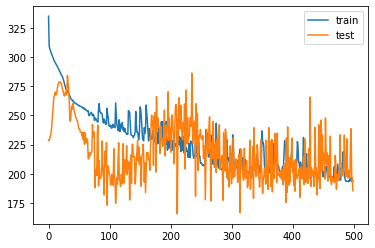

In [49]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
history = model.fit(X_train, y_train, epochs=500, batch_size=256, \
                    validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(X_train)
y_pred = y_scaler.inverse_transform(yhat)
y_real = y_scaler.inverse_transform(y_train)
plt.figure()
plt.plot(y_real[:,0],label = 'Real')
plt.plot(y_pred[:,0],label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_pred, y_real, squared=False)
rms